# **Electronics Design for Biomedical Instrumentation**

##Lab Session - Artifical Neural Networks for Imaging in Monolithic Scintillator Crystals

Filippo Ghisio: &lt; filippo.ghisio@polimi.it&gt;



# **Import libraries**


In [109]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

In [110]:
from sklearn.model_selection import train_test_split

In [111]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

2.18.0


In [112]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# **Mount Google Drive**


In [113]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [114]:
# Set your directory
root_path = '/content/gdrive/MyDrive/Challenge_Electronic_Design'
os.chdir(root_path)

# **Classification Problem - 4 Classes**

## Load and inspect the data

In [115]:
data = pd.read_csv('Classification.csv').values

In [116]:
print("Shape of the dataset:", data.shape)

Shape of the dataset: (66620, 65)


As you can see, the dataset contains 66,620 rows and 65 columns.

Each row represent an event.

Each event is composed of the signals from the 64 SiPMs and a value for the class (1 to 4).

Let's inspect the dataset...

In [117]:
print("First event (64 SiPMs signals and class):\n", data[0,:])
print("\n")
print("Last event (64 SiPMs signals and class):\n", data[66619,:])

First event (64 SiPMs signals and class):
 [3158 4840 4639 1984 3722 1376 1218 1436 5572 5559 5817 5119 3250 2401
 4470 5022 5854 5496 5307 5699 4668 4478 2609 4036 5150 3839 2690 4430
 1302 1613 1272 4078 4900 3678 5586 5158 5906 4652 4865 5700 1340 1576
 1635 3504 3519 4848 1795 4549 1438 1553 3383 1440 5532 2246 5186 3492
 3092 4400 5457 5323 5350 5496 5617 4828    1]


Last event (64 SiPMs signals and class):
 [3365 4427 4310 2270 3636 1352 1392 1348 5305 5308 5688 5464 4058 2332
 4503 5238 6014 5812 6028 6279 5345 4744 2788 4237 5398 3922 2761 4936
 1316 1594 1302 4578 3961 3411 4814 4323 5432 4660 4774 4837 1300 1702
 1598 3573 3234 5122 1774 4472 1378 1532 3584 1555 5121 2268 5302 3355
 2876 3912 5341 4066 5214 5056 5670 4756    4]


Let's see an image representing the SiPMs signals in the first / last event...

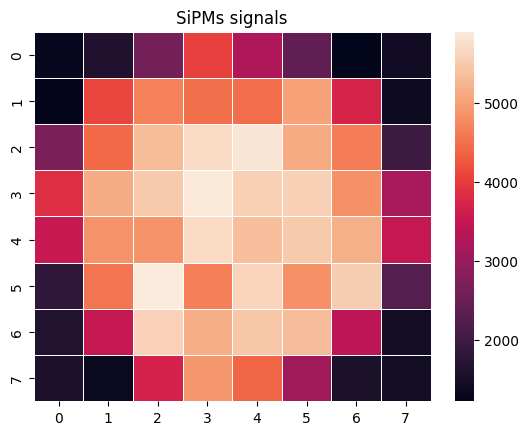

In [118]:
event = data[0,:]
#event = data[66619,:]

IMG = [[event[28], event[29], event[22], event[23], event[12], event[13], event[6], event[7]],
      [event[30], event[31], event[20], event[21], event[14], event[15], event[4], event[5]],
      [event[26], event[27], event[18], event[19], event[10], event[11], event[2], event[3]],
      [event[25], event[24], event[17], event[16], event[9], event[8], event[1], event[0]],
      [event[44], event[45], event[38], event[39], event[60], event[61], event[54], event[55]],
      [event[46], event[47], event[36], event[37], event[62], event[63], event[52], event[53]],
      [event[42], event[43], event[34], event[35], event[58], event[59], event[50], event[51]],
      [event[41], event[40], event[33], event[32], event[57], event[56], event[49], event[48]]]

ax = sns.heatmap(IMG, linewidth=0.5)
ax.set_title('SiPMs signals');
plt.show()

Let's check whether the dataset is balanced...

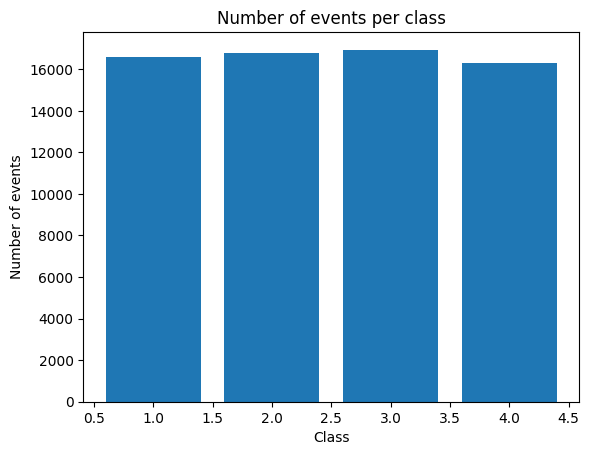

In [119]:
classes = data[:,-1]
unique_classes, class_counts = np.unique(classes, return_counts=True)

plt.bar(unique_classes, class_counts)
plt.xlabel('Class')
plt.ylabel('Number of events')
plt.title('Number of events per class')
plt.show()

## Create the dataset

In [120]:
x = data[:, :-1]  # 64 SiPMs signals (features)
y = data[:, 64]   # Labels (classifications)
y-=1 #Convert labels from 1-4 to 0-3 as required by ML models

In [121]:
print("Shape of feature matrix (x):", x.shape)
print("Shape of labels (y):", y.shape)
print("Adjusted labels (y):", y)

Shape of feature matrix (x): (66620, 64)
Shape of labels (y): (66620,)
Adjusted labels (y): [0 0 0 ... 3 3 3]


## Train, Validation, Test Split

In [122]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=42)

In [123]:
print("Shape of x_train:", x_train.shape) # The expected shape for the rows is 46634 (i.e. 66620 * 70 / 100)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (46634, 64)
Shape of y_train: (46634,)
Shape of x_test: (19986, 64)
Shape of y_test: (19986,)


In [124]:
print("First training sample: \n", x_train[0,:])
print("\nFirst training label:", y_train[0])

# Note: Data is split randomly, so the first sample in the training set
# does not match the first sample from the original dataset.

First training sample: 
 [2906 4148 3760 1931 3401 1098 1129  997 5198 4670 4976 4892 3686 2208
 4140 4783 5622 4658 4776 4578 3974 4196 2599 3497 4698 3438 2354 3646
  700 1398 1048 3711 7606 4412 5968 7269 5096 4684 4244 4658 1459 1521
 1441 3307 3388 4661 1621 4332 1353 1464 3582 1485 4968 2378 4474 3358
 3544 7506 7078 5381 4633 4956 5871 4768]

First training label: 1


In [125]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [126]:
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_valid:", x_valid.shape)
print("Shape of y_valid:", y_valid.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (37307, 64)
Shape of y_train: (37307,)
Shape of x_valid: (9327, 64)
Shape of y_valid: (9327,)
Shape of x_test: (19986, 64)
Shape of y_test: (19986,)


## Data Normalization and Preparation

Let's normalize data, event per event, bringing all the values between 0 and 1

In [127]:
x_train_normalized = np.zeros_like(x_train, dtype=float)

for i in range(x_train.shape[0]):  # Iterate over the events
    row = x_train[i]
    min_val = np.min(row)
    max_val = np.max(row)

    x_train_normalized[i] = (row - min_val) / (max_val - min_val)

In [128]:
# Verification for the first event (example)
print("Original values for the first event:")
print(x_train[0])

min_val_first_event = np.min(x_train[0])
max_val_first_event = np.max(x_train[0])

print("\nMin and Max values for the first event:")
print("Min:", min_val_first_event)
print("Max:", max_val_first_event)

print("\nNormalized values for the first event:")
print(x_train_normalized[0])

Original values for the first event:
[3236 4777 4397 1952 3934 1223 1266 1234 5572 5460 5448 5674 3334 2389
 4474 5550 5714 5276 5498 5854 4838 4561 2923 3676 5232 4123 2400 4402
 1146 1439 1221 3836 4380 3756 5002 4882 5506 4635 4612 5234 1280 1535
 1489 3533 3488 4645 1627 4518 1386 1400 3978 1412 4979 2325 5090 3410
 3239 3892 5388 4847 5288 5294 5760 4592]

Min and Max values for the first event:
Min: 1146
Max: 5854

Normalized values for the first event:
[0.44392523 0.77124044 0.69052676 0.17119796 0.59218352 0.01635514
 0.02548853 0.01869159 0.94010195 0.91631266 0.91376381 0.9617672
 0.46474087 0.26401869 0.7068819  0.93542906 0.97026338 0.87723025
 0.92438403 1.         0.78419711 0.72536109 0.37744265 0.53738318
 0.86788445 0.63232795 0.26635514 0.69158879 0.         0.06223449
 0.01593033 0.57136788 0.68691589 0.55437553 0.81903144 0.79354291
 0.92608326 0.74107901 0.73619371 0.86830926 0.02846219 0.08262532
 0.07285472 0.50700935 0.49745115 0.74320306 0.10216653 0.7162277
 0

Let's do the same for validation...

In [129]:
# Create an empty array with the same shape as x_train, but with float data type
x_valid_normalized = np.zeros_like(x_valid, dtype=float)

# Loop through each row of the dataset
for i in range(x_valid.shape[0]):  # Iterate over the 37307 events
    row = x_valid[i]  # Get the i-th event
    min_val = np.min(row)  # Find the minimum value in the event
    max_val = np.max(row)  # Find the maximum value in the event

    x_valid_normalized[i] = (row - min_val) / (max_val - min_val)

REMEMBER: The same normalization process must be applied at test time on the new test data

Let's apply one hot encoding to the labels

In [130]:
y_train_one_hot = to_categorical(y_train, num_classes=4)
y_valid_one_hot = to_categorical(y_valid, num_classes=4)

print("First original y_train sample (before one-hot encoding):")
print(y_train[0])
print("First one-hot encoded y_train sample:")
print(y_train_one_hot[0])
print("")

print("Last original y_valid sample (before one-hot encoding):")
print(y_valid[-1])
print("Last one-hot encoded y_valid sample:")
print(y_valid_one_hot[-1])

First original y_train sample (before one-hot encoding):
1
First one-hot encoded y_train sample:
[0. 1. 0. 0.]

Last original y_valid sample (before one-hot encoding):
2
Last one-hot encoded y_valid sample:
[0. 0. 1. 0.]


In [131]:
x_train = x_train_normalized
x_valid = x_valid_normalized
y_train = y_train_one_hot
y_valid = y_valid_one_hot

## Model Definition

In [132]:
Input_Layer_Nodes = 64;  # It must be the same as the number of SiPMs signals
Output_Layer_Nodes = 4;  # It must be the same as the number of classes

Output_Layer_Activation_Function = 'softmax';

In [133]:
model = Sequential(name='Model')

model.add(Input(shape=(Input_Layer_Nodes,), name = 'Input'))
model.add(Dense(units=128, activation='relu', name = 'Hidden1'))
model.add(Dense(units=64, activation='relu', name = 'Hidden2'))
model.add(Dense(units=32, activation='relu', name = 'Hidden3'))
model.add(Dense(units=16, activation='relu', name = 'Hidden4'))
model.add(Dense(units=Output_Layer_Nodes, activation=Output_Layer_Activation_Function, name = 'Output'))

In [134]:
learning_rate = 0.01  #Important parameter. Trade-off is needed.
optimizer = Adam(learning_rate=learning_rate)
Loss_Function = 'categorical_crossentropy'

model.compile(optimizer=optimizer, loss=Loss_Function, metrics=['accuracy'])

model.summary()

Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,252 (75.20 KB)

 Trainable params: 19,252 (75.20 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [135]:
batch_size = 1024
epochs = 100

# EarlyStopping callback to stop training if validation loss does not improve
patience = 15
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Training the model
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_valid, y_valid) ,
    callbacks=[early_stopping],
    verbose=1  # Display progress bar and training details
)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.2609 - loss: 1.3845 - val_accuracy: 0.4057 - val_loss: 1.2300
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4434 - loss: 1.1448 - val_accuracy: 0.5796 - val_loss: 0.9191
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5716 - loss: 0.9193 - val_accuracy: 0.6564 - val_loss: 0.8211
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6275 - loss: 0.8298 - val_accuracy: 0.6230 - val_loss: 0.7933
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6679 - loss: 0.7441 - val_accuracy: 0.6677 - val_loss: 0.7090
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7034 - loss: 0.6972 - val_accuracy: 0.7128 - val_loss: 0.6808
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7173 - loss: 0.6669 - val_accuracy: 0.7053 - val_loss: 0.6538
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7240 - loss: 0.6582 - val_accuracy: 0.6873 - 

## Model Evaluation

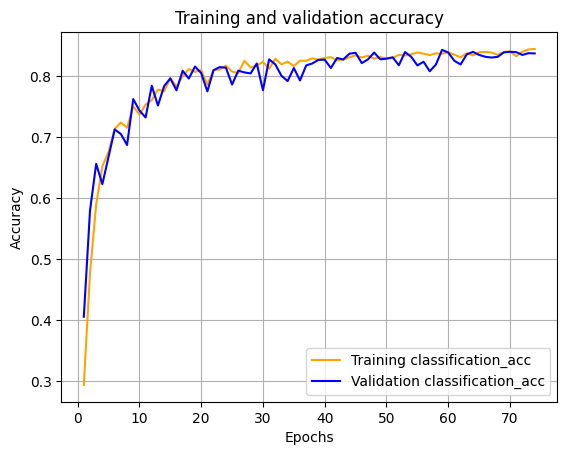

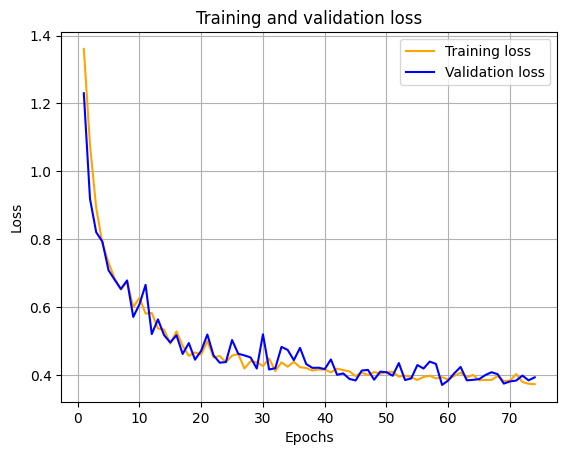

In [136]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.plot(epochs, acc, 'orange', label='Training classification_acc')
plt.plot(epochs, val_acc, 'b', label='Validation classification_acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plotting training and validation loss
plt.figure()
plt.plot(epochs, loss, 'orange', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [137]:
#Compute predictions

y_pred = model.predict(x_valid)
y_pred_classes = np.argmax(y_pred, axis=1)

292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [138]:
print("Network output for the first event on the validation set:")
print(y_pred[0])
print("\nPrediction for the first event on the validation set:")
print(y_pred_classes[0])

Network output for the first event on the validation set:
[0.06010863 0.89992386 0.03741033 0.00255722]

Prediction for the first event on the validation set:
1


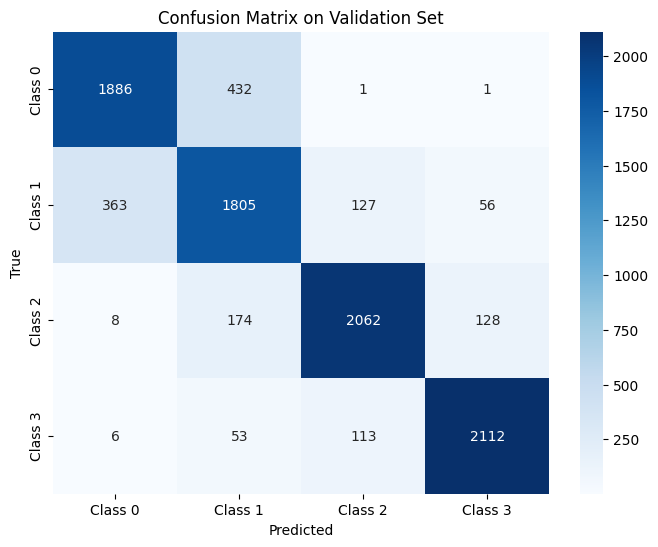

In [139]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute Confusion Matrix
y_true = np.argmax(y_valid_one_hot, axis=1)

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Validation Set')
plt.show()

In [140]:
from sklearn.metrics import classification_report

# Calcolare precision, recall e f1-score
report = classification_report(y_true, y_pred_classes, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
print(report)

              precision    recall  f1-score   support

     Class 0       0.83      0.81      0.82      2320
     Class 1       0.73      0.77      0.75      2351
     Class 2       0.90      0.87      0.88      2372
     Class 3       0.92      0.92      0.92      2284

    accuracy                           0.84      9327
   macro avg       0.85      0.84      0.84      9327
weighted avg       0.84      0.84      0.84      9327



## Using the model on the test set

Let's apply the same normalization procedure on x_train and the one-hot-encoding on y_test

In [141]:
x_test_normalized = np.zeros_like(x_test, dtype=float)

for i in range(x_test.shape[0]):
    row = x_test[i]
    min_val = np.min(row)
    max_val = np.max(row)

    x_test_normalized[i] = (row - min_val) / (max_val - min_val)

In [142]:
y_test_one_hot = to_categorical(y_test, num_classes=4)

In [143]:
x_test = x_test_normalized
y_test = y_test_one_hot

Now, let's make predictions...

In [144]:
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_true_test = np.argmax(y_test, axis=1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [145]:
print("Predicted probabilities for the first sample (raw output from softmax):")
print(y_pred_test[0])
print("")

print("Predicted class for the first sample:")
print(y_pred_test_classes[0])

Predicted probabilities for the first sample (raw output from softmax):
[0.07707402 0.87767357 0.03932761 0.00592476]

Predicted class for the first sample:
1


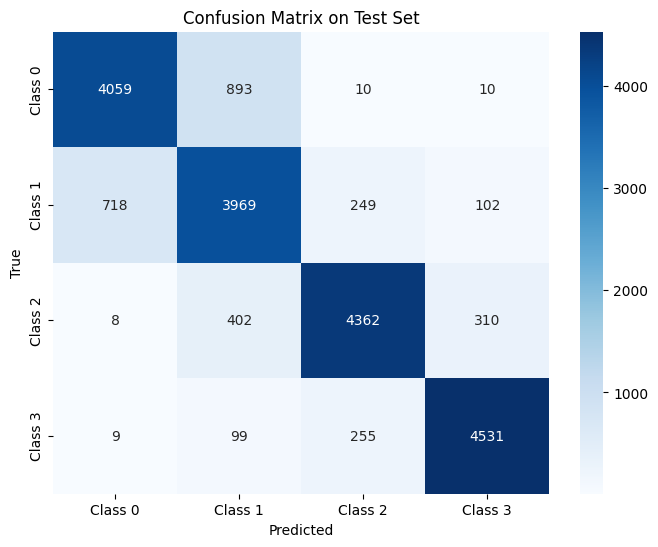

In [146]:
cm = confusion_matrix(y_true_test, y_pred_test_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()

In [147]:
from sklearn.metrics import classification_report

report = classification_report(y_true_test, y_pred_test_classes, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
print(report)

              precision    recall  f1-score   support

     Class 0       0.85      0.82      0.83      4972
     Class 1       0.74      0.79      0.76      5038
     Class 2       0.89      0.86      0.88      5082
     Class 3       0.91      0.93      0.92      4894

    accuracy                           0.85     19986
   macro avg       0.85      0.85      0.85     19986
weighted avg       0.85      0.85      0.85     19986



# **Regression Problem**

## Data loading and inspection, and dataset preparation

In [148]:
data = pd.read_csv('Regression_Train.csv').values

print("Shape of the dataset:", data.shape)
print("")
print("First event (64 SiPMs signals and coordinates):\n", data[0,:])
print("")
print("Last event (64 SiPMs signals and coordinates):\n", data[-1,:])

Shape of the dataset: (264552, 66)

First event (64 SiPMs signals and coordinates):
 [1995.    3199.    2491.    2093.    3186.    1902.    2002.    1562.
 3030.    3444.    3196.    2644.    1808.    2349.    2834.    2857.
 4594.    4180.    2782.    3174.    3188.    2641.    2045.    2072.
 4112.    2206.    2220.    3470.    1578.    2062.    1877.    3062.
 2196.    2541.    3044.    3078.    2774.    2680.    3422.    3494.
 2584.    1740.    2209.    2935.    2330.    3335.    2057.    3076.
 2063.    2390.    2206.    2036.    2409.    2114.    2706.    1932.
 2285.    2766.    3008.    1762.    2921.    2766.    2344.    2634.
   34.375   28.125]

Last event (64 SiPMs signals and coordinates):
 [2162.    2799.    2862.    2094.    3050.    2185.    2318.    1718.
 3254.    3432.    4088.    3522.    2440.    2717.    4225.    3084.
 3280.    2466.    2625.    5243.    4012.    4290.    2237.    2742.
 3456.    1929.    2075.    3049.    1663.    2316.    1868.    3332.
 2190.

In [149]:
x = data[:, :64]
y = data[:, -2:]

In [150]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, random_state=42)

In [151]:
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)

print("Shape of x_valid:", x_valid.shape)
print("Shape of y_valid:", y_valid.shape)

Shape of x_train: (198414, 64)
Shape of y_train: (198414, 2)
Shape of x_valid: (66138, 64)
Shape of y_valid: (66138, 2)


In [152]:
x_train_normalized = np.zeros_like(x_train, dtype=float)

for i in range(x_train.shape[0]):
    row = x_train[i]
    min_val = np.min(row)
    max_val = np.max(row)

    x_train_normalized[i] = (row - min_val) / (max_val - min_val)

In [153]:
x_valid_normalized = np.zeros_like(x_valid, dtype=float)

for i in range(x_valid.shape[0]):
    row = x_valid[i]
    min_val = np.min(row)
    max_val = np.max(row)

    x_valid_normalized[i] = (row - min_val) / (max_val - min_val)

In [154]:
x_train = x_train_normalized
x_valid = x_valid_normalized

## Model Definition and Training

In [155]:
Input_Layer_Nodes = 64;  # It must be the same as the number of SiPMs signals
Output_Layer_Nodes = 2;  # It must be the same as the number of coordinates to predict

Output_Layer_Activation_Function = 'linear';

In [159]:
from tensorflow.keras.layers import Dropout
model = Sequential(name='Model')

model.add(Input(shape=(Input_Layer_Nodes,), name = 'Input'))

model.add(Dense(units=128, activation='relu', name = 'Hidden1'))
model.add(Dropout(rate=0.2, name='Dropout1'))
model.add(Dense(units=64, activation='relu', name = 'Hidden2'))
model.add(Dropout(rate=0.2, name='Dropout2'))
model.add(Dense(units=32, activation='relu', name = 'Hidden3'))
model.add(Dropout(rate=0.2, name='Dropout3'))
model.add(Dense(units=16, activation='relu', name = 'Hidden4'))
model.add(Dense(units=32, activation='relu', name = 'Hidden5'))

model.add(Dense(units=Output_Layer_Nodes, activation=Output_Layer_Activation_Function, name = 'Output'))

In [160]:
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)
Loss_Function = 'mse'  # Loss function used for regression problems (Mean Squared Error)

model.compile(optimizer=optimizer, loss=Loss_Function, metrics=['mae'])

model.summary()

Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout2 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout3 (Dropout)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden5 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,794 (77.32 KB)

 Trainable params: 19,794 (77.32 KB)

 Non-trainable params: 0 (0.00 B)

In [161]:
batch_size = 1024
epochs = 400

patience = 35
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_valid, y_valid) ,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/400
194/194 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 238.9393 - mae: 11.9200 - val_loss: 54.6969 - val_mae: 5.6508
Epoch 2/400
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 47.0173 - mae: 4.9084 - val_loss: 33.9564 - val_mae: 4.2008
Epoch 3/400
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 35.8967 - mae: 4.1969 - val_loss: 36.2476 - val_mae: 4.4824
Epoch 4/400
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 31.0635 - mae: 3.8363 - val_loss: 30.4820 - val_mae: 3.9812
Epoch 5/400
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 29.1187 - mae: 3.6701 - val_loss: 27.7963 - val_mae: 3.6928
Epoch 6/400
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 27.8917 - mae: 3.5830 - val_loss: 29.1672 - val_mae: 3.8532
Epoch 7/400
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 26.8379 - mae: 3.4890 - val_loss: 26.2603 - val_mae: 3.5908
Epoch 8/400
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 26.7830 - mae: 3.4667 - val_loss: 24.2808 - val_mae: 3.3679
Epoch 9/400
194/194 ━━━━━━━━━

## Model Evaluation

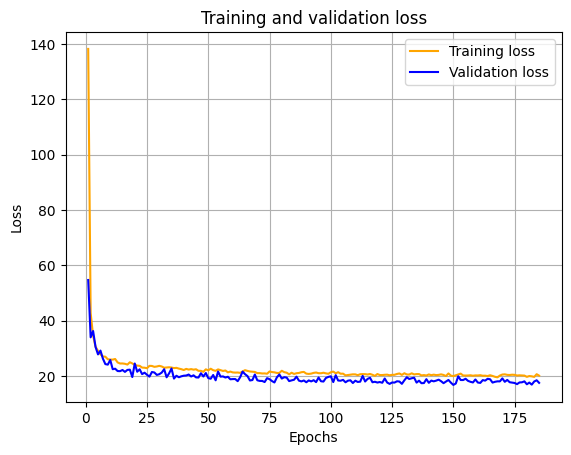

In [162]:
# Plotting the results
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting training and validation loss
plt.figure()
plt.plot(epochs, loss, 'orange', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [163]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred_val = model.predict(x_valid)

mae_val = mean_absolute_error(y_valid, y_pred_val)
print(f"Mean Absolute Error (MAE) on validation data: {mae_val:.4f}")

mse_val = mean_squared_error(y_valid, y_pred_val)
print(f"Mean Squared Error (MSE) on validation data: {mse_val:.4f}")

rmse_val = np.sqrt(mse_val)
print(f"Root Mean Squared Error (RMSE) on validation data: {rmse_val:.4f}")

custom_metric = (mae_val + rmse_val) / 2
print(f"Custom Metric (Mean of MAE and RMSE) on validation data: {custom_metric:.4f}")

2067/2067 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Mean Absolute Error (MAE) on validation data: 2.3852
Mean Squared Error (MSE) on validation data: 16.7545
Root Mean Squared Error (RMSE) on validation data: 4.0932
Custom Metric (Mean of MAE and RMSE) on validation data: 3.2392


## Save Model

In [165]:
##model.save("NameOfTheModel.keras")

# **Student Battle**

In [166]:
x_test = pd.read_csv('Regression_Test_Without_Labels.csv').values
print("Shape of the dataset:", x_test.shape)
print("\nFirst event (64 SiPMs signals):\n", x_test[0,:])

Shape of the dataset: (66138, 64)

First event (64 SiPMs signals):
 [2049 2810 2582 1758 2735 1962 1972 1582 3133 3372 2680 2660 1683 2028
 2626 2697 3110 3149 1920 2206 2714 2287 1912 1886 3162 1734 1822 2430
 1632 1716 1985 2466 3028 2885 4158 4538 3422 3757 3344 3954 2982 1897
 2348 3434 2064 3631 2212 3390 2015 2826 2192 2039 2518 2232 2884 1878
 2488 3552 4260 2164 3616 3677 3882 3293]


In [167]:
#COMPLETE

In [168]:
y_pred_test = model.predict(x_test_normalized)

print("\nShape of predictions:", y_pred_test.shape)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Shape of predictions: (19986, 2)


In [180]:
print(y_pred_test[1,:])

[ 9.232261 21.608831]


Check that the shape of the predictions is coherent with what you expect!




Create a CSV file containing your predictions.
NB: The chosen nickname will be shown on the leaderboard

In [ ]:
#my_nickname = "CHOOSE_NICKNAME"

#df_y_pred = pd.DataFrame(y_pred_test)
#file_name = f"{my_nickname}.csv"
#df_y_pred.to_csv(file_name, index=False)